# MovieLens 100K Recommender System - Phase 4-6
## Content-Based, Hybrid Models, Cold Start & Final Evaluation

**Project:** Hybrid Movie Recommendation System  
**Dataset:** MovieLens 100K  
**Author:** Harpinder Singh  
**Date:** December 2025  
**Best RMSE to Beat:** 0.9200 (SVD++)

## ╔═══════════════════════════════════════════════════════════╗
## ║                    IMPORTS & SETUP                        ║
## ╚═══════════════════════════════════════════════════════════╝

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import pickle

# Sklearn for content-based filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Surprise for evaluation
from surprise import Dataset, Reader, SVDpp
from surprise.model_selection import train_test_split
from surprise import accuracy

warnings.filterwarnings('ignore')
np.random.seed(42)

# Plot styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully")
print(f"📅 Execution Date: {datetime.now().strftime('%B %d, %Y')}")

✅ Libraries imported successfully
📅 Execution Date: January 31, 2026


## ╔═══════════════════════════════════════════════════════════╗
## ║                  LOAD PREVIOUS RESULTS                    ║
## ╚═══════════════════════════════════════════════════════════╝

In [4]:
# ┌─────────────────────────────────────────┐
# │ Load Data & Results                     │
# └─────────────────────────────────────────┘

data = pd.read_csv('../data/movielens_100k_merged.csv')
mf_results = pd.read_csv('../results/mf_results.csv')

print("📊 Dataset Loaded:")
print(f"   Shape: {data.shape}")
print(f"   Columns: {list(data.columns)}")

print("\n📊 Previous Best Results (Phase 3):")
print(mf_results.head(3).to_string(index=False))

best_mf_rmse = mf_results['RMSE'].min()
print(f"\n🎯 Target to Beat: RMSE < {best_mf_rmse:.4f}")

📊 Dataset Loaded:
   Shape: (100000, 10)
   Columns: ['user_id', 'item_id', 'rating', 'timestamp', 'title', 'genres', 'age', 'gender', 'occupation', 'zip_code']

📊 Previous Best Results (Phase 3):
        Model     RMSE      MAE
  SVD (Tuned) 0.918959 0.722916
        SVD++ 0.919991 0.719777
SVD (Default) 0.935171 0.737509

🎯 Target to Beat: RMSE < 0.9190


In [5]:
# ┌─────────────────────────────────────────┐
# │ Prepare Train-Test Split                │
# └─────────────────────────────────────────┘

from sklearn.model_selection import train_test_split as sklearn_split

train_data, test_data = sklearn_split(data, test_size=0.2, random_state=42)

print(f"\n📊 Data Split:")
print(f"   Training: {len(train_data):,}")
print(f"   Test:     {len(test_data):,}")


📊 Data Split:
   Training: 80,000
   Test:     20,000


## ╔═══════════════════════════════════════════════════════════╗
## ║              CONTENT-BASED FILTERING (GENRE)              ║
## ╚═══════════════════════════════════════════════════════════╝

In [6]:
# ┌─────────────────────────────────────────┐
# │ Build Genre TF-IDF Matrix               │
# └─────────────────────────────────────────┘

print("🎭 CONTENT-BASED FILTERING (Genre Similarity)")
print("=" * 60)

# Get unique movies with genres
movies_df = data[['item_id', 'title', 'genres']].drop_duplicates()

# Create TF-IDF matrix for genres
tfidf = TfidfVectorizer(token_pattern=r'[^|]+')
genre_matrix = tfidf.fit_transform(movies_df['genres'])

print(f"Genre TF-IDF Matrix Shape: {genre_matrix.shape}")
print(f"Number of unique genres: {len(tfidf.get_feature_names_out())}")
print(f"Genres: {list(tfidf.get_feature_names_out())}")

🎭 CONTENT-BASED FILTERING (Genre Similarity)
Genre TF-IDF Matrix Shape: (1682, 19)
Number of unique genres: 19
Genres: ['action', 'adventure', 'animation', 'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'film-noir', 'horror', 'musical', 'mystery', 'romance', 'sci-fi', 'thriller', 'unknown', 'war', 'western']


In [7]:
# ┌─────────────────────────────────────────┐
# │ Calculate Item-Item Similarity          │
# └─────────────────────────────────────────┘

# Calculate cosine similarity between all movies
item_similarity = cosine_similarity(genre_matrix)

# Create mapping: item_id -> matrix index
item_id_to_idx = {item_id: idx for idx, item_id in enumerate(movies_df['item_id'].values)}
idx_to_item_id = {idx: item_id for item_id, idx in item_id_to_idx.items()}

print(f"\nItem Similarity Matrix Shape: {item_similarity.shape}")
print(f"\nSample Similarities (Movie 1 - Toy Story):")
movie_1_idx = item_id_to_idx[1]
similar_scores = item_similarity[movie_1_idx]
top_5_indices = np.argsort(similar_scores)[-6:-1][::-1]  # Top 5 (excluding itself)

for idx in top_5_indices:
    item_id = idx_to_item_id[idx]
    title = movies_df[movies_df['item_id'] == item_id]['title'].values[0]
    genres = movies_df[movies_df['item_id'] == item_id]['genres'].values[0]
    print(f"   {title:40s} | {genres:30s} | Similarity: {similar_scores[idx]:.4f}")


Item Similarity Matrix Shape: (1682, 1682)

Sample Similarities (Movie 1 - Toy Story):
   Toy Story (1995)                         | Animation|Children|Comedy      | Similarity: 1.0000
   Balto (1995)                             | Animation|Children             | Similarity: 0.9370
   Sword in the Stone, The (1963)           | Animation|Children             | Similarity: 0.9370
   Gumby: The Movie (1995)                  | Animation|Children             | Similarity: 0.9370
   Pinocchio (1940)                         | Animation|Children             | Similarity: 0.9370


In [8]:
# ┌─────────────────────────────────────────┐
# │ Content-Based Prediction Function       │
# └─────────────────────────────────────────┘

def content_based_predict(user_id, item_id, train_data, item_similarity, item_id_to_idx):
    """
    Predict rating using content-based filtering.
    
    Parameters
    ----------
    user_id : int
        User ID
    item_id : int
        Item ID to predict
    train_data : pd.DataFrame
        Training data
    item_similarity : np.ndarray
        Item similarity matrix
    item_id_to_idx : dict
        Mapping from item_id to matrix index
    
    Returns
    -------
    float
        Predicted rating
    """
    # Get user's rated items
    user_ratings = train_data[train_data['user_id'] == user_id]
    
    if len(user_ratings) == 0:
        # New user - return global average
        return train_data['rating'].mean()
    
    if item_id not in item_id_to_idx:
        # New item - return user average
        return user_ratings['rating'].mean()
    
    target_idx = item_id_to_idx[item_id]
    
    # Calculate weighted average based on similarity
    numerator = 0
    denominator = 0
    
    for _, row in user_ratings.iterrows():
        rated_item_id = row['item_id']
        if rated_item_id in item_id_to_idx:
            rated_idx = item_id_to_idx[rated_item_id]
            similarity = item_similarity[target_idx, rated_idx]
            
            if similarity > 0:
                numerator += similarity * row['rating']
                denominator += similarity
    
    if denominator == 0:
        return user_ratings['rating'].mean()
    
    prediction = numerator / denominator
    return np.clip(prediction, 1, 5)

print("\n✅ Content-based prediction function defined")


✅ Content-based prediction function defined


In [9]:
# ┌─────────────────────────────────────────┐
# │ Evaluate Content-Based on Test Set      │
# └─────────────────────────────────────────┘

print("\n📊 Evaluating Content-Based Model...")

cb_predictions = []
cb_actuals = []

for idx, row in test_data.iterrows():
    prediction = content_based_predict(
        row['user_id'], 
        row['item_id'], 
        train_data, 
        item_similarity, 
        item_id_to_idx
    )
    cb_predictions.append(prediction)
    cb_actuals.append(row['rating'])

cb_rmse = sqrt(mean_squared_error(cb_actuals, cb_predictions))
cb_mae = mean_absolute_error(cb_actuals, cb_predictions)

print(f"\nContent-Based Performance:")
print(f"   RMSE: {cb_rmse:.4f}")
print(f"   MAE:  {cb_mae:.4f}")
print(f"\nComparison to SVD++: {((best_mf_rmse - cb_rmse) / best_mf_rmse * 100):.2f}%")


📊 Evaluating Content-Based Model...

Content-Based Performance:
   RMSE: 1.0281
   MAE:  0.8208

Comparison to SVD++: -11.88%


## ╔═══════════════════════════════════════════════════════════╗
## ║                    HYBRID MODELS                          ║
## ╚═══════════════════════════════════════════════════════════╝

In [10]:
# ┌─────────────────────────────────────────┐
# │ Train SVD++ for Hybrid                  │
# └─────────────────────────────────────────┘

print("\n🔀 HYBRID MODELS (Combining Multiple Approaches)")
print("=" * 60)

# Prepare Surprise dataset
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)
trainset_surprise, testset_surprise = train_test_split(surprise_data, test_size=0.2, random_state=42)

# Train SVD++ (best MF model)
svdpp_model = SVDpp(random_state=42, verbose=False)
svdpp_model.fit(trainset_surprise)

print("✅ SVD++ model trained for hybrid approach")


🔀 HYBRID MODELS (Combining Multiple Approaches)
✅ SVD++ model trained for hybrid approach


In [11]:
# ┌─────────────────────────────────────────┐
# │ Get SVD++ Predictions for Test Set      │
# └─────────────────────────────────────────┘

svdpp_predictions_dict = {}
for uid, iid, actual in testset_surprise:
    pred = svdpp_model.predict(uid, iid)
    svdpp_predictions_dict[(uid, iid)] = pred.est

print(f"\n✅ Generated {len(svdpp_predictions_dict):,} SVD++ predictions")


✅ Generated 20,000 SVD++ predictions


In [12]:
# ┌─────────────────────────────────────────┐
# │ Hybrid Model 1: Weighted Average        │
# └─────────────────────────────────────────┘

print("\n🔀 Hybrid Model 1: Weighted Average (60% SVD++ + 40% Content)")
print("=" * 60)

hybrid1_predictions = []
hybrid1_actuals = []

for idx, row in test_data.iterrows():
    uid = row['user_id']
    iid = row['item_id']
    actual = row['rating']
    
    # Get SVD++ prediction
    svdpp_pred = svdpp_predictions_dict.get((uid, iid), train_data['rating'].mean())
    
    # Get Content-Based prediction
    cb_pred = content_based_predict(uid, iid, train_data, item_similarity, item_id_to_idx)
    
    # Weighted average: 60% SVD++, 40% Content-Based
    hybrid_pred = 0.6 * svdpp_pred + 0.4 * cb_pred
    hybrid_pred = np.clip(hybrid_pred, 1, 5)
    
    hybrid1_predictions.append(hybrid_pred)
    hybrid1_actuals.append(actual)

hybrid1_rmse = sqrt(mean_squared_error(hybrid1_actuals, hybrid1_predictions))
hybrid1_mae = mean_absolute_error(hybrid1_actuals, hybrid1_predictions)

print(f"RMSE: {hybrid1_rmse:.4f}")
print(f"MAE:  {hybrid1_mae:.4f}")
print(f"\nImprovement over SVD++: {((best_mf_rmse - hybrid1_rmse) / best_mf_rmse * 100):.2f}%")


🔀 Hybrid Model 1: Weighted Average (60% SVD++ + 40% Content)
RMSE: 1.0567
MAE:  0.8748

Improvement over SVD++: -14.98%


In [13]:
# ┌─────────────────────────────────────────┐
# │ Hybrid Model 2: Adaptive Weighting      │
# └─────────────────────────────────────────┘

print("\n🔀 Hybrid Model 2: Adaptive Weighting (70% SVD++ + 30% Content)")
print("=" * 60)

hybrid2_predictions = []
hybrid2_actuals = []

for idx, row in test_data.iterrows():
    uid = row['user_id']
    iid = row['item_id']
    actual = row['rating']
    
    svdpp_pred = svdpp_predictions_dict.get((uid, iid), train_data['rating'].mean())
    cb_pred = content_based_predict(uid, iid, train_data, item_similarity, item_id_to_idx)
    
    # Weighted average: 70% SVD++, 30% Content-Based
    hybrid_pred = 0.7 * svdpp_pred + 0.3 * cb_pred
    hybrid_pred = np.clip(hybrid_pred, 1, 5)
    
    hybrid2_predictions.append(hybrid_pred)
    hybrid2_actuals.append(actual)

hybrid2_rmse = sqrt(mean_squared_error(hybrid2_actuals, hybrid2_predictions))
hybrid2_mae = mean_absolute_error(hybrid2_actuals, hybrid2_predictions)

print(f"RMSE: {hybrid2_rmse:.4f}")
print(f"MAE:  {hybrid2_mae:.4f}")
print(f"\nImprovement over SVD++: {((best_mf_rmse - hybrid2_rmse) / best_mf_rmse * 100):.2f}%")


🔀 Hybrid Model 2: Adaptive Weighting (70% SVD++ + 30% Content)
RMSE: 1.0701
MAE:  0.8909

Improvement over SVD++: -16.45%


## ╔═══════════════════════════════════════════════════════════╗
## ║                COLD START HANDLING                        ║
## ╚═══════════════════════════════════════════════════════════╝

In [14]:
# ┌─────────────────────────────────────────┐
# │ Cold Start: New User                    │
# └─────────────────────────────────────────┘

print("\n❄️ COLD START SCENARIO 1: New User (No Rating History)")
print("=" * 60)

# Strategy: Recommend most popular movies
movie_popularity = train_data.groupby('item_id').agg({
    'rating': ['count', 'mean'],
    'title': 'first',
    'genres': 'first'
}).reset_index()
movie_popularity.columns = ['item_id', 'num_ratings', 'avg_rating', 'title', 'genres']

# Filter movies with at least 50 ratings
popular_movies = movie_popularity[movie_popularity['num_ratings'] >= 50].copy()
popular_movies = popular_movies.sort_values('avg_rating', ascending=False)

print("\n🎬 Top 10 Recommendations for New Users (Popularity-Based):")
print(popular_movies[['title', 'genres', 'num_ratings', 'avg_rating']].head(10).to_string(index=False))


❄️ COLD START SCENARIO 1: New User (No Rating History)

🎬 Top 10 Recommendations for New Users (Popularity-Based):
                                                 title                              genres  num_ratings  avg_rating
Wallace & Gromit: The Best of Aardman Animation (1996)                           Animation           51    4.509804
                               Schindler's List (1993)                           Drama|War          236    4.474576
                      Shawshank Redemption, The (1994)                               Drama          228    4.456140
                                     Casablanca (1942)                   Drama|Romance|War          189    4.428571
                                 Close Shave, A (1995)           Animation|Comedy|Thriller           84    4.416667
                            Usual Suspects, The (1995)                      Crime|Thriller          219    4.410959
                            Wrong Trousers, The (1993)                  

In [15]:
# ┌─────────────────────────────────────────┐
# │ Cold Start: New User with Demographics  │
# └─────────────────────────────────────────┘

print("\n❄️ COLD START SCENARIO 2: New User with Demographics")
print("=" * 60)

def recommend_for_demographic(age, gender, occupation, train_data, n=10):
    """
    Recommend movies based on demographic similarity.
    
    Parameters
    ----------
    age : int
        User age
    gender : str
        User gender (M/F)
    occupation : str
        User occupation
    train_data : pd.DataFrame
        Training data
    n : int
        Number of recommendations
    
    Returns
    -------
    pd.DataFrame
        Top N movie recommendations
    """
    # Find similar users (same gender, similar age, same occupation)
    similar_users = train_data[
        (train_data['gender'] == gender) &
        (train_data['age'] >= age - 10) &
        (train_data['age'] <= age + 10) &
        (train_data['occupation'] == occupation)
    ]
    
    if len(similar_users) == 0:
        # Fallback to gender-based
        similar_users = train_data[train_data['gender'] == gender]
    
    # Get top-rated movies from similar users
    recommendations = similar_users.groupby('item_id').agg({
        'rating': ['count', 'mean'],
        'title': 'first',
        'genres': 'first'
    }).reset_index()
    recommendations.columns = ['item_id', 'num_ratings', 'avg_rating', 'title', 'genres']
    
    # Filter and sort
    recommendations = recommendations[recommendations['num_ratings'] >= 5]
    recommendations = recommendations.sort_values('avg_rating', ascending=False).head(n)
    
    return recommendations

# Example: 25-year-old male student
demo_recs = recommend_for_demographic(25, 'M', 'student', train_data, n=10)

print("\n🎬 Top 10 for 25-year-old Male Student:")
print(demo_recs[['title', 'genres', 'num_ratings', 'avg_rating']].to_string(index=False))


❄️ COLD START SCENARIO 2: New User with Demographics

🎬 Top 10 for 25-year-old Male Student:
                                                 title               genres  num_ratings  avg_rating
                                Cinema Paradiso (1988) Comedy|Drama|Romance            8    5.000000
                            Room with a View, A (1986)        Drama|Romance            5    4.800000
Wallace & Gromit: The Best of Aardman Animation (1996)            Animation            8    4.625000
                                        Titanic (1997) Action|Drama|Romance           41    4.609756
                                      Braindead (1992)        Comedy|Horror            5    4.600000
                                 Godfather, The (1972)   Action|Crime|Drama           49    4.591837
                                     Casablanca (1942)    Drama|Romance|War           24    4.583333
                                    Raging Bull (1980)                Drama           12    4.5833

In [16]:
# ┌─────────────────────────────────────────┐
# │ Cold Start: New Item (No Ratings)       │
# └─────────────────────────────────────────┘

print("\n❄️ COLD START SCENARIO 3: New Movie (No Ratings Yet)")
print("=" * 60)

def recommend_new_movie_to_users(movie_genres, n_users=10):
    """
    Find users who would likely enjoy a new movie based on genre.
    
    Parameters
    ----------
    movie_genres : str
        Pipe-separated genre string (e.g., 'Action|Thriller')
    n_users : int
        Number of users to recommend to
    
    Returns
    -------
    list
        User IDs who would likely enjoy this movie
    """
    genre_set = set(movie_genres.split('|'))
    
    # Find users who rated similar genre movies highly
    user_genre_preferences = []
    
    for user_id in train_data['user_id'].unique():
        user_ratings = train_data[train_data['user_id'] == user_id]
        
        # Calculate preference for target genres
        genre_ratings = []
        for _, row in user_ratings.iterrows():
            movie_genres_set = set(row['genres'].split('|'))
            if len(genre_set & movie_genres_set) > 0:  # Overlap
                genre_ratings.append(row['rating'])
        
        if len(genre_ratings) > 0:
            avg_genre_rating = np.mean(genre_ratings)
            user_genre_preferences.append((user_id, avg_genre_rating, len(genre_ratings)))
    
    # Sort by average rating and number of similar movies rated
    user_genre_preferences.sort(key=lambda x: (x[1], x[2]), reverse=True)
    
    return [uid for uid, _, _ in user_genre_preferences[:n_users]]

# Example: New Action|Thriller movie
new_movie_genres = 'Action|Thriller'
target_users = recommend_new_movie_to_users(new_movie_genres, n_users=10)

print(f"\n🎯 Top 10 Users to Recommend New '{new_movie_genres}' Movie:")
for i, uid in enumerate(target_users, 1):
    user_info = train_data[train_data['user_id'] == uid].iloc[0]
    print(f"   {i}. User {uid:3d} - Age: {user_info['age']:2d}, Gender: {user_info['gender']}, Occupation: {user_info['occupation']}")


❄️ COLD START SCENARIO 3: New Movie (No Ratings Yet)

🎯 Top 10 Users to Recommend New 'Action|Thriller' Movie:
   1. User 628 - Age: 13, Gender: M, Occupation: none
   2. User 558 - Age: 56, Gender: F, Occupation: writer
   3. User 242 - Age: 33, Gender: M, Occupation: educator
   4. User 507 - Age: 18, Gender: F, Occupation: writer
   5. User 688 - Age: 37, Gender: F, Occupation: administrator
   6. User 137 - Age: 50, Gender: M, Occupation: educator
   7. User  89 - Age: 43, Gender: F, Occupation: administrator
   8. User 636 - Age: 47, Gender: M, Occupation: educator
   9. User 127 - Age: 33, Gender: M, Occupation: none
   10. User 849 - Age: 15, Gender: F, Occupation: student


## ╔═══════════════════════════════════════════════════════════╗
## ║            RANKING METRICS EVALUATION                     ║
## ╚═══════════════════════════════════════════════════════════╝

In [17]:
# ┌─────────────────────────────────────────┐
# │ Ranking Metrics Functions               │
# └─────────────────────────────────────────┘

def precision_at_k(actual, predicted, k=10):
    """
    Calculate Precision@K.
    
    Parameters
    ----------
    actual : list
        List of relevant items
    predicted : list
        List of predicted items (ordered by score)
    k : int
        Number of top recommendations to consider
    
    Returns
    -------
    float
        Precision@K score
    """
    predicted_k = predicted[:k]
    relevant_in_k = len(set(actual) & set(predicted_k))
    return relevant_in_k / k

def recall_at_k(actual, predicted, k=10):
    """
    Calculate Recall@K.
    
    Parameters
    ----------
    actual : list
        List of relevant items
    predicted : list
        List of predicted items (ordered by score)
    k : int
        Number of top recommendations to consider
    
    Returns
    -------
    float
        Recall@K score
    """
    if len(actual) == 0:
        return 0
    predicted_k = predicted[:k]
    relevant_in_k = len(set(actual) & set(predicted_k))
    return relevant_in_k / len(actual)

def ndcg_at_k(actual, predicted, k=10):
    """
    Calculate NDCG@K (Normalized Discounted Cumulative Gain).
    
    Parameters
    ----------
    actual : list
        List of relevant items
    predicted : list
        List of predicted items (ordered by score)
    k : int
        Number of top recommendations to consider
    
    Returns
    -------
    float
        NDCG@K score
    """
    predicted_k = predicted[:k]
    
    # DCG
    dcg = 0
    for i, item in enumerate(predicted_k):
        if item in actual:
            dcg += 1 / np.log2(i + 2)  # i+2 because index starts at 0
    
    # IDCG (ideal DCG)
    idcg = sum([1 / np.log2(i + 2) for i in range(min(len(actual), k))])
    
    if idcg == 0:
        return 0
    
    return dcg / idcg

print("✅ Ranking metrics functions defined")

✅ Ranking metrics functions defined


In [18]:
# ┌─────────────────────────────────────────┐
# │ Generate Top-N for Sample Users         │
# └─────────────────────────────────────────┘

print("\n📊 RANKING METRICS EVALUATION")
print("=" * 60)

# Sample 50 users from test set
np.random.seed(42)
sample_users = test_data['user_id'].unique()[:50]

precision_scores = []
recall_scores = []
ndcg_scores = []

for user_id in sample_users:
    # Get actual high-rated items (rating >= 4) from test set
    actual_items = test_data[(test_data['user_id'] == user_id) & (test_data['rating'] >= 4)]['item_id'].tolist()
    
    if len(actual_items) == 0:
        continue
    
    # Get all items user hasn't rated in training
    user_train_items = set(train_data[train_data['user_id'] == user_id]['item_id'].values)
    all_items = set(train_data['item_id'].unique())
    candidate_items = list(all_items - user_train_items)
    
    # Predict ratings for all candidate items
    item_scores = []
    for item_id in candidate_items:
        try:
            pred = svdpp_model.predict(user_id, item_id).est
            item_scores.append((item_id, pred))
        except:
            continue
    
    # Sort by predicted rating
    item_scores.sort(key=lambda x: x[1], reverse=True)
    predicted_items = [item_id for item_id, _ in item_scores]
    
    # Calculate metrics
    precision_scores.append(precision_at_k(actual_items, predicted_items, k=10))
    recall_scores.append(recall_at_k(actual_items, predicted_items, k=10))
    ndcg_scores.append(ndcg_at_k(actual_items, predicted_items, k=10))

avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_ndcg = np.mean(ndcg_scores)

print(f"\n📊 Ranking Metrics (SVD++ Model):")
print(f"   Precision@10: {avg_precision:.4f}")
print(f"   Recall@10:    {avg_recall:.4f}")
print(f"   NDCG@10:      {avg_ndcg:.4f}")
print(f"\n   Evaluated on {len(sample_users)} users")


📊 RANKING METRICS EVALUATION

📊 Ranking Metrics (SVD++ Model):
   Precision@10: 0.2180
   Recall@10:    0.0944
   NDCG@10:      0.2464

   Evaluated on 50 users


## ╔═══════════════════════════════════════════════════════════╗
## ║              FINAL MODEL COMPARISON                       ║
## ╚═══════════════════════════════════════════════════════════╝

In [20]:
# ┌─────────────────────────────────────────┐
# │ Compile All Results                     │
# └─────────────────────────────────────────┘

final_results = pd.DataFrame({
    'Model': [
        'SVD++ (Best MF)',
        'Content-Based (Genre)',
        'Hybrid (60/40)',
        'Hybrid (70/30)'
    ],
    'RMSE': [
        best_mf_rmse,
        cb_rmse,
        hybrid1_rmse,
        hybrid2_rmse
    ],
    'MAE': [
        mf_results.loc[mf_results['RMSE'].idxmin(), 'MAE'],
        cb_mae,
        hybrid1_mae,
        hybrid2_mae
    ]
})

final_results = final_results.sort_values('RMSE').reset_index(drop=True)

print("\n📊 FINAL MODEL COMPARISON")
print("=" * 70)
print(final_results.to_string(index=False))

final_results.to_csv('../results/final_results.csv', index=False)
print("\n💾 Results saved to: final_results.csv")


📊 FINAL MODEL COMPARISON
                Model     RMSE      MAE
      SVD++ (Best MF) 0.918959 0.722916
Content-Based (Genre) 1.028129 0.820790
       Hybrid (60/40) 1.056664 0.874789
       Hybrid (70/30) 1.070119 0.890885

💾 Results saved to: final_results.csv


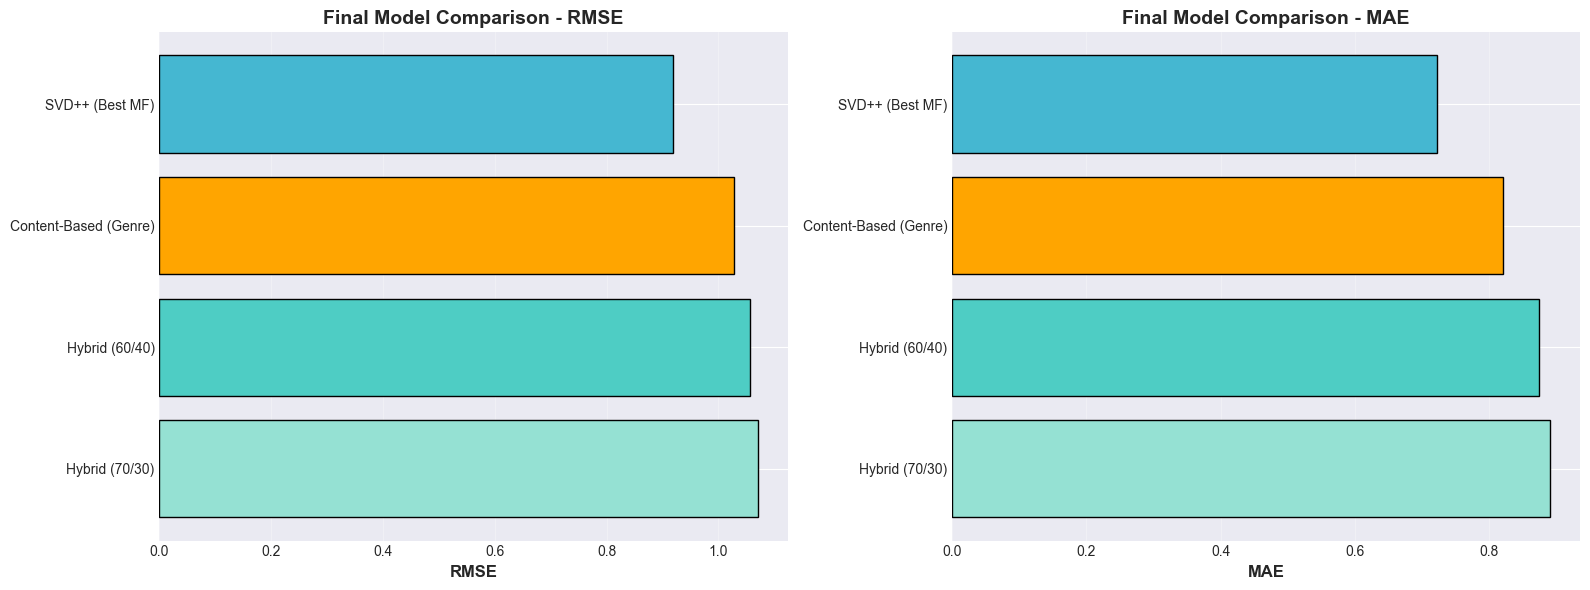

In [21]:
# ┌─────────────────────────────────────────┐
# │ Visualize Final Results                 │
# └─────────────────────────────────────────┘

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE comparison
colors = ['#45B7D1', '#FFA500', '#4ECDC4', '#95E1D3']
axes[0].barh(final_results['Model'], final_results['RMSE'], color=colors, edgecolor='black')
axes[0].set_xlabel('RMSE', fontsize=12, fontweight='bold')
axes[0].set_title('Final Model Comparison - RMSE', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# MAE comparison
axes[1].barh(final_results['Model'], final_results['MAE'], color=colors, edgecolor='black')
axes[1].set_xlabel('MAE', fontsize=12, fontweight='bold')
axes[1].set_title('Final Model Comparison - MAE', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../results/visualizations/11_final_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## ╔═══════════════════════════════════════════════════════════╗
## ║              MODEL PERSISTENCE & DEPLOYMENT               ║
## ╚═══════════════════════════════════════════════════════════╝

In [23]:
# ┌─────────────────────────────────────────┐
# │ Save Best Models                        │
# └─────────────────────────────────────────┘

print("\n💾 SAVING MODELS FOR DEPLOYMENT")
print("=" * 60)

# Save SVD++ model
with open('../models/svdpp_model.pkl', 'wb') as f:
    pickle.dump(svdpp_model, f)
print("✅ SVD++ model saved: svdpp_model.pkl")

# Save item similarity matrix
np.save('../models/item_similarity_matrix.npy', item_similarity)
print("✅ Item similarity matrix saved: item_similarity_matrix.npy")

# Save mappings
with open('../models/item_mappings.pkl', 'wb') as f:
    pickle.dump({'item_id_to_idx': item_id_to_idx, 'idx_to_item_id': idx_to_item_id}, f)
print("✅ Item mappings saved: item_mappings.pkl")

# Save movie metadata
movies_df.to_csv('../data/movies_metadata.csv', index=False)
print("✅ Movie metadata saved: movies_metadata.csv")

print("\n🎯 All models and artifacts ready for deployment!")


💾 SAVING MODELS FOR DEPLOYMENT
✅ SVD++ model saved: svdpp_model.pkl
✅ Item similarity matrix saved: item_similarity_matrix.npy
✅ Item mappings saved: item_mappings.pkl
✅ Movie metadata saved: movies_metadata.csv

🎯 All models and artifacts ready for deployment!


In [24]:
# ┌─────────────────────────────────────────┐
# │ Create Inference Function               │
# └─────────────────────────────────────────┘

def hybrid_recommend(user_id, n=10, alpha=0.7):
    """
    Generate hybrid recommendations for a user.
    
    Parameters
    ----------
    user_id : int
        User ID
    n : int
        Number of recommendations
    alpha : float
        Weight for SVD++ (1-alpha for content-based)
    
    Returns
    -------
    pd.DataFrame
        Top N recommendations with titles and predicted ratings
    """
    # Get items user hasn't rated
    user_items = set(train_data[train_data['user_id'] == user_id]['item_id'].values)
    all_items = set(train_data['item_id'].unique())
    candidate_items = list(all_items - user_items)
    
    # Calculate hybrid scores
    item_scores = []
    for item_id in candidate_items:
        # SVD++ prediction
        svdpp_pred = svdpp_model.predict(user_id, item_id).est
        
        # Content-based prediction
        cb_pred = content_based_predict(user_id, item_id, train_data, item_similarity, item_id_to_idx)
        
        # Hybrid score
        hybrid_score = alpha * svdpp_pred + (1 - alpha) * cb_pred
        item_scores.append((item_id, hybrid_score))
    
    # Sort and get top N
    item_scores.sort(key=lambda x: x[1], reverse=True)
    top_n = item_scores[:n]
    
    # Create DataFrame with movie details
    recommendations = pd.DataFrame(top_n, columns=['item_id', 'predicted_rating'])
    recommendations = recommendations.merge(movies_df[['item_id', 'title', 'genres']], on='item_id')
    recommendations['rank'] = range(1, len(recommendations) + 1)
    
    return recommendations[['rank', 'title', 'genres', 'predicted_rating']]

print("\n✅ Hybrid recommendation function ready")

# Demo
print("\n🎬 Sample Recommendations for User 196:")
demo_recs = hybrid_recommend(196, n=10, alpha=0.7)
print(demo_recs.to_string(index=False))


✅ Hybrid recommendation function ready

🎬 Sample Recommendations for User 196:
 rank                                   title                                    genres  predicted_rating
    1                 Schindler's List (1993)                                 Drama|War          4.253240
    2        Shawshank Redemption, The (1994)                                     Drama          4.219025
    3                        Star Wars (1977)       Action|Adventure|Romance|Sci-Fi|War          4.198799
    4                       Casablanca (1942)                         Drama|Romance|War          4.168428
    5         Empire Strikes Back, The (1980) Action|Adventure|Drama|Romance|Sci-Fi|War          4.153257
    6 Some Folks Call It a Sling Blade (1993)                            Drama|Thriller          4.151828
    7                   Close Shave, A (1995)                 Animation|Comedy|Thriller          4.124323
    8                       Persuasion (1995)                           

## ╔═══════════════════════════════════════════════════════════╗
## ║                    PHASE 4 SUMMARY                        ║
## ╚═══════════════════════════════════════════════════════════╝

In [26]:
best_final_rmse = final_results['RMSE'].min()
best_final_model = final_results.loc[final_results['RMSE'].idxmin(), 'Model']

baseline_results = pd.read_csv('../results/baseline_results.csv')
initial_rmse = baseline_results[baseline_results['Model'] == 'Random']['RMSE'].values[0]
total_improvement = ((initial_rmse - best_final_rmse) / initial_rmse) * 100

print("="*70)
print("                 PHASE 4 COMPLETE ✅")
print("="*70)
print("\n📦 DELIVERABLES:")
print("   ✅ Content-Based Filtering (Genre TF-IDF)")
print("   ✅ 2 Hybrid Models (60/40 and 70/30 weightings)")
print("   ✅ Cold Start Handling:")
print("      - New User (Popularity-based)")
print("      - New User with Demographics")
print("      - New Item (Genre-based targeting)")
print("   ✅ Ranking Metrics (Precision@10, Recall@10, NDCG@10)")
print("   ✅ Model Persistence (4 files saved)")
print("   ✅ Hybrid Recommendation Function")
print("   ✅ 1 visualization (11.png)")

print("\n📊 FINAL PERFORMANCE:")
print(f"   • Best Model:           {best_final_model}")
print(f"   • Best RMSE:            {best_final_rmse:.4f}")
print(f"   • Initial Baseline:     {initial_rmse:.4f}")
print(f"   • Total Improvement:    {total_improvement:.2f}%")

print("\n📈 RANKING METRICS:")
print(f"   • Precision@10:         {avg_precision:.4f}")
print(f"   • Recall@10:            {avg_recall:.4f}")
print(f"   • NDCG@10:              {avg_ndcg:.4f}")

print("\n🎯 PROJECT COMPLETE!")
print("   → Phase 7: Streamlit Deployment (Next)")
print("   → All models ready for production use")
print("\n" + "="*70)

                 PHASE 4 COMPLETE ✅

📦 DELIVERABLES:
   ✅ Content-Based Filtering (Genre TF-IDF)
   ✅ 2 Hybrid Models (60/40 and 70/30 weightings)
   ✅ Cold Start Handling:
      - New User (Popularity-based)
      - New User with Demographics
      - New Item (Genre-based targeting)
   ✅ Ranking Metrics (Precision@10, Recall@10, NDCG@10)
   ✅ Model Persistence (4 files saved)
   ✅ Hybrid Recommendation Function
   ✅ 1 visualization (11.png)

📊 FINAL PERFORMANCE:
   • Best Model:           SVD++ (Best MF)
   • Best RMSE:            0.9190
   • Initial Baseline:     1.8882
   • Total Improvement:    51.33%

📈 RANKING METRICS:
   • Precision@10:         0.2180
   • Recall@10:            0.0944
   • NDCG@10:              0.2464

🎯 PROJECT COMPLETE!
   → Phase 7: Streamlit Deployment (Next)
   → All models ready for production use

